# DQNを実装する
## TODO
1. SARSAやモンテカルロ法も試してみる
2. 状態の変数をいくつか欠落させても学習できるのかを実験
3. すでに学習済みのQ関数を使ってGYMを動かし、そのmemoryのみでうまく学習できるかを実験

In [145]:
import random
import numpy as np
import copy
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [146]:
env = gym.make('CartPole-v0')
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n

In [147]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(obs_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, act_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [148]:
q_net = DQN().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(q_net.parameters(), lr=0.0001)#, alpha=0.95, eps=0.01)

q_net_tmp = copy.deepcopy(q_net)

In [149]:
def obs2device(obs_np):
    obs_np = obs_np.astype('float32') #float64だとpytorchでエラーがでる
    obs = torch.from_numpy(obs_np)
    obs = obs.view(-1, obs_size)
    return obs.to(device)

### Memory

In [150]:
# make an element for Replay Memory
def make_memory(obs_np, q_net_tmp, epsilon, step):
    q_net_tmp.eval()
    obs = obs2device(obs_np)
    qs = q_net_tmp(obs)
    act = qs.data.numpy().argmax()
    if np.random.rand() < epsilon:
        act = env.action_space.sample()
    nxt_obs_np, rew, done, info = env.step(act)
    if done:
        if step < 195:
            rew = -1
        else:
            rew = 1
    else:
        rew = 0
    # 状態、行動、報酬、行動後の状態、ゲーム終了フラグ
    return (obs_np, act, rew, nxt_obs_np, done)

In [151]:
dones

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False,  True])

In [152]:
dones.shape

(32,)

In [153]:
obss = obs2device(obss_np)
q_net(obss).size()

torch.Size([32, 2])

In [154]:
%%time
EPISODE_NUM = 500
BATCH_SIZE = 32
GAMMA = 0.99
EPSILON_INIT = 0.5
EPSILON_REDUCTION = 0.005
EPSILON_MIN = 0.1
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

memory = []
epsilon = EPSILON_INIT
obs_np = env.reset()
done = False

total_rew_log = []
loss_log = []

for i in range(BATCH_SIZE):
    if done or step > 195:
        obs_np = env.reset()
        total_rew = 0
        step = 0
    tmp = make_memory(obs_np, q_net_tmp, epsilon, step)
    memory.append(tmp)
    obs_np = tmp[3]
    done = tmp[-1]
    rew = tmp[2]
    

for episode_i in range(EPISODE_NUM):

    # Replay Memory: 現状のNNで環境を動かした結果を蓄積
    total_rew = 0
    step = 0
    done = False
    obs_np = env.reset()
    for i in range(201):
        if done:
            if step >= 195:
                total_rew = 1
            total_rew_log.append(total_rew)
            break
        tmp = make_memory(obs_np, q_net_tmp, epsilon, step)
        memory.append(tmp)
        # memoryが十分溜まっているなら古い方から削除
        if len(memory) > MEMORY_SIZE:
            memory.pop(0)
        obs_np = tmp[3]
        done = tmp[-1]
        rew = tmp[2]
        total_rew += rew
        step += 1
        
        
        batch = np.array(random.sample(memory, BATCH_SIZE)) # 経験ミニバッチ
        obss_np = np.array(batch[:,0].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_size))
        acts = np.array(batch[:,1].tolist(), dtype="int32")
        rews = np.array(batch[:,2].tolist(), dtype="int32")
        nxt_obss_np = np.array(batch[:,3].tolist(), dtype="float32").reshape((BATCH_SIZE, obs_size))
        dones = np.array(batch[:,4].tolist(), dtype="bool")
        
        obss = obs2device(obss_np)
        q_net.eval()
        qses = q_net(obss)
        
        nxt_obss = obs2device(nxt_obss_np)
        q_net_tmp.eval()
        nxt_qses = q_net_tmp(nxt_obss)
        max_nxt_qs, _ = torch.max(nxt_qses.data, 1)
        target = qses.clone()
        # RMで実際に取った行動の箇所だけ更新
        # (それ以外の行動については更新しない → Lossが0なので更新されない)
        for j in range(BATCH_SIZE):
            target[j, acts[j]] = rews[j] + GAMMA * max_nxt_qs[j] * (not dones[j])
        optimizer.zero_grad()
        q_net.train()
        loss = criterion(qses, target)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
    
    # 固定していたnetの更新
    if episode_i % TARGET_UPDATE == 0:
        q_net_tmp = copy.deepcopy(q_net)

    # EPSILONを下げる
    if epsilon > EPSILON_MIN:
        epsilon -= EPSILON_REDUCTION
    
    # 各stepを平均して表示
    if episode_i % 20 == 0:
        print(step)
#         print(sum(total_rew_log[-20:])/20)
        
    # 10回中9回成功したら強制終了
    if (sum(total_rew_log[-10:])/10) >= 0.9:
        break

15
12
10
10
11
13
130
39
186
89
105
71
69
100
98
69
147
200
CPU times: user 48.2 s, sys: 286 ms, total: 48.5 s
Wall time: 48.8 s


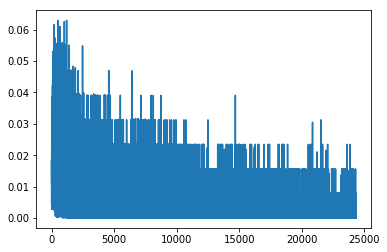

In [155]:
# LOSSの変化
left = np.array(range(len(loss_log)))
height = np.array(loss_log)
plt.plot(left, height)

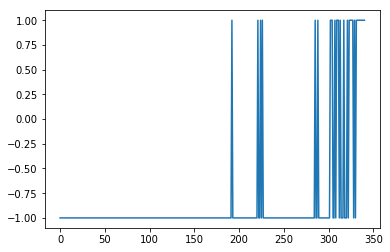

In [156]:
# REWARDの変化
left = np.array(range(len(total_rew_log)))
height = np.array(total_rew_log)
plt.plot(left, height)

## 学習済みのQ関数でGYMを動かす

In [158]:
obs_np = env.reset()
step = 0
done = False
while not done and step < 200:
    tmp = make_memory(obs_np, q_net, 0.1, step)
    obs_np = tmp[3]
    done = tmp[-1]
    env.render()
    step += 1
print(step)
env.close()

119
